In [1]:
import warnings
import pandas as pd
import mplfinance as mpf
import numpy as np
import random
import torch
import torch.optim as optim
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST
import os

from trainer import fit
from datasets import SiameseMNIST, TripletMNIST, BalancedBatchSampler
from metrics import AccumulatedAccuracyMetric, AverageNonzeroTripletsMetric
from networks import EmbeddingNet, ClassificationNet, SiameseNet, TripletNet
from losses import ContrastiveLoss, TripletLoss, OnlineContrastiveLoss, OnlineTripletLoss

from utils import HardNegativePairSelector  # Strategies for selecting pairs within a minibatch
from utils import RandomNegativeTripletSelector  # Strategies for selecting triplets within a minibatch
from utils import set_all_seeds
warnings.filterwarnings("ignore")

In [2]:
set_all_seeds(29)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
buy_patterns_clusters = np.load('/siamese-triplet/data/buy_patterns_clusters.npy')
buy_patterns = np.load('/siamese-triplet/data/buy_patterns.npy')
sell_patterns_clusters = np.load('/siamese-triplet/data/sell_patterns_clusters.npy')
sell_patterns = np.load('/siamese-triplet/data/sell_patterns.npy')

print(f'buy_patterns_clusters shape: {buy_patterns_clusters.shape}')
print(f'buy_patterns shape: {buy_patterns.shape}')
print(f'sell_patterns_clusters shape: {sell_patterns_clusters.shape}')
print(f'sell_patterns shape: {sell_patterns.shape}')

buy_patterns_clusters shape: (30,)
buy_patterns shape: (30, 60, 5)
sell_patterns_clusters shape: (25,)
sell_patterns shape: (25, 60, 5)


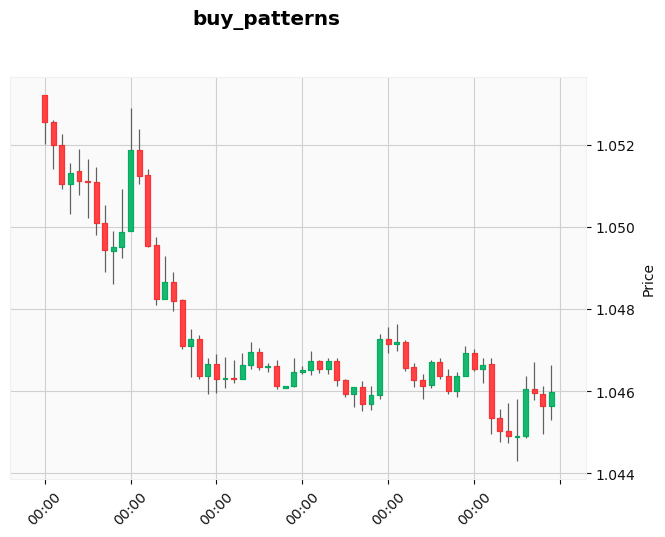

In [5]:
data_buy = pd.DataFrame({
    'Date': [i for i in range(buy_patterns[:,:,0][0].shape[0])],
    'Open': buy_patterns[:,:,0][0],
    'High': buy_patterns[:,:,1][0],
    'Low': buy_patterns[:,:,2][0],
    'Close': buy_patterns[:,:,3][0],
    'Volume': buy_patterns[:,:,4][0]
})

data_buy['Date'] = pd.to_datetime(data_buy['Date'])
data_buy.set_index('Date', inplace=True)

mpf.plot(data_buy, type='candle', style='yahoo', title='buy_patterns')


In [6]:
buy_patterns_clusters

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

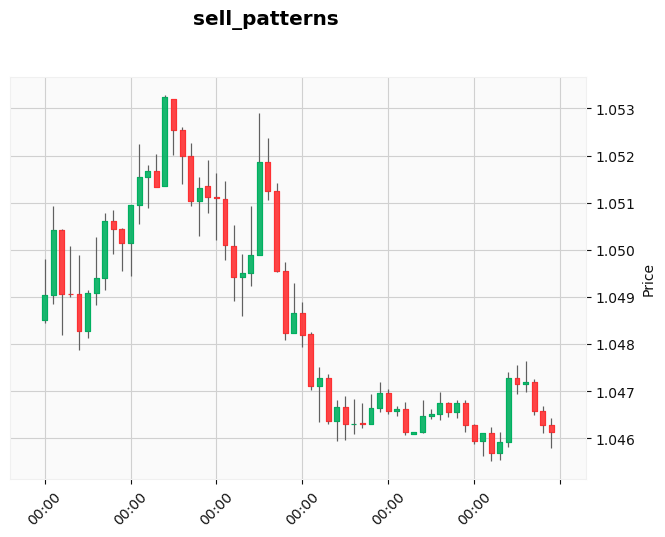

In [7]:
data_sell = pd.DataFrame({
    'Date': [i for i in range(buy_patterns[:,:,0][0].shape[0])],
    'Open': sell_patterns[:,:,0][0],
    'High': sell_patterns[:,:,1][0],
    'Low': sell_patterns[:,:,2][0],
    'Close': sell_patterns[:,:,3][0],
    'Volume': sell_patterns[:,:,4][0]
})


data_sell['Date'] = pd.to_datetime(data_sell['Date'])
data_sell.set_index('Date', inplace=True)
data_sell['Open']

mpf.plot(data_sell, type='candle', style='yahoo', title='sell_patterns')


In [8]:
n_classes = 4
mnist_classes = ['0', '1', '2', '3']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
cuda = torch.cuda.is_available()

def plot_embeddings(embeddings, targets, title=None, xlim=None, ylim=None):
    plt.figure(figsize=(10, 10))
    for i in range(4):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)
    plt.title(title)
    plt.show()

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

In [9]:
from sklearn.model_selection import train_test_split

x = np.concatenate([buy_patterns, sell_patterns]).reshape(55, 1, 60, 5)
y = np.concatenate([buy_patterns_clusters, sell_patterns_clusters+2])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, 
                                                    shuffle=True, stratify=y, random_state=29)

train_dataset = [(torch.from_numpy(x_train[i]).double(), torch.tensor(y_train[i], dtype=torch.long)) for i in range(len(y_train))]
test_dataset = [(torch.from_numpy(x_test[i]).double(), torch.tensor(y_test[i], dtype=torch.long)) for i in range(len(y_test))]

x_train = torch.from_numpy(x_train).double()
x_test = torch.from_numpy(x_test).double()
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)


1. Baseline - classification with softmax:
Train: [0/44 (0%)]	Loss: 4.444635	Accuracy: 12.5

Epoch: 1/20. Train set: Average loss: 2645.5274	Accuracy: 22.727272727272727
Epoch: 1/20. Validation set: Average loss: 11048.6162	Accuracy: 36.36363636363637
Train: [0/44 (0%)]	Loss: 11619.624650	Accuracy: 43.75

Epoch: 2/20. Train set: Average loss: 4347.1897	Accuracy: 29.545454545454547
Epoch: 2/20. Validation set: Average loss: 169.3103	Accuracy: 18.181818181818183
Train: [0/44 (0%)]	Loss: 238.159466	Accuracy: 12.5

Epoch: 3/20. Train set: Average loss: 219.8739	Accuracy: 31.818181818181817
Epoch: 3/20. Validation set: Average loss: 335.7844	Accuracy: 36.36363636363637
Train: [0/44 (0%)]	Loss: 267.369288	Accuracy: 50.0

Epoch: 4/20. Train set: Average loss: 321.9547	Accuracy: 27.272727272727273
Epoch: 4/20. Validation set: Average loss: 272.1197	Accuracy: 36.36363636363637
Train: [0/44 (0%)]	Loss: 184.234561	Accuracy: 56.25

Epoch: 5/20. Train set: Average loss: 191.6696	Accuracy: 40.90909

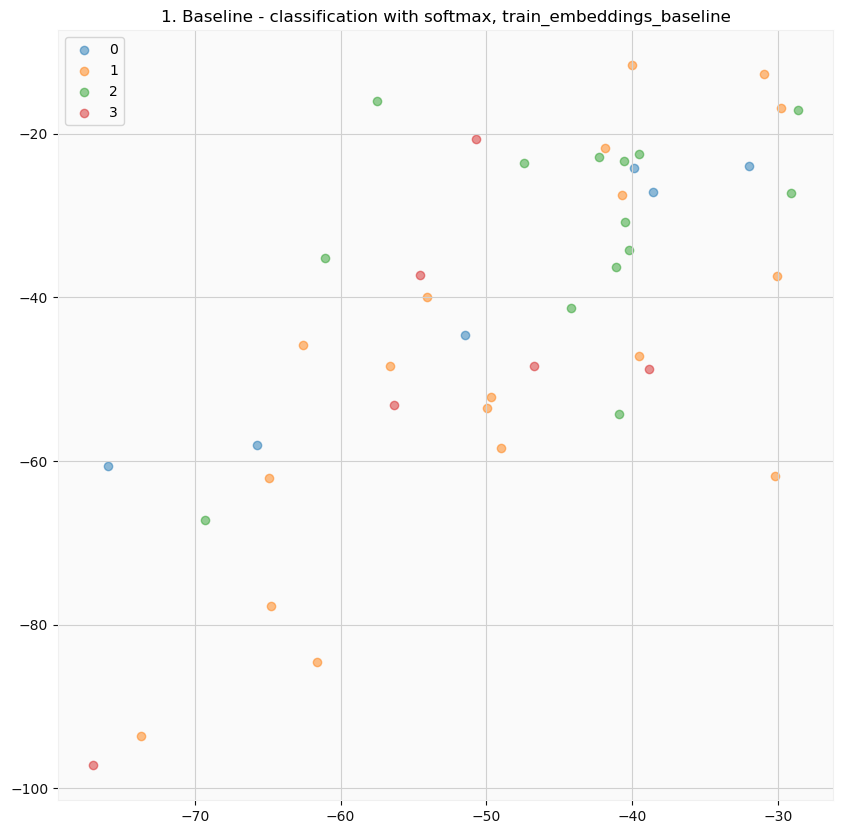

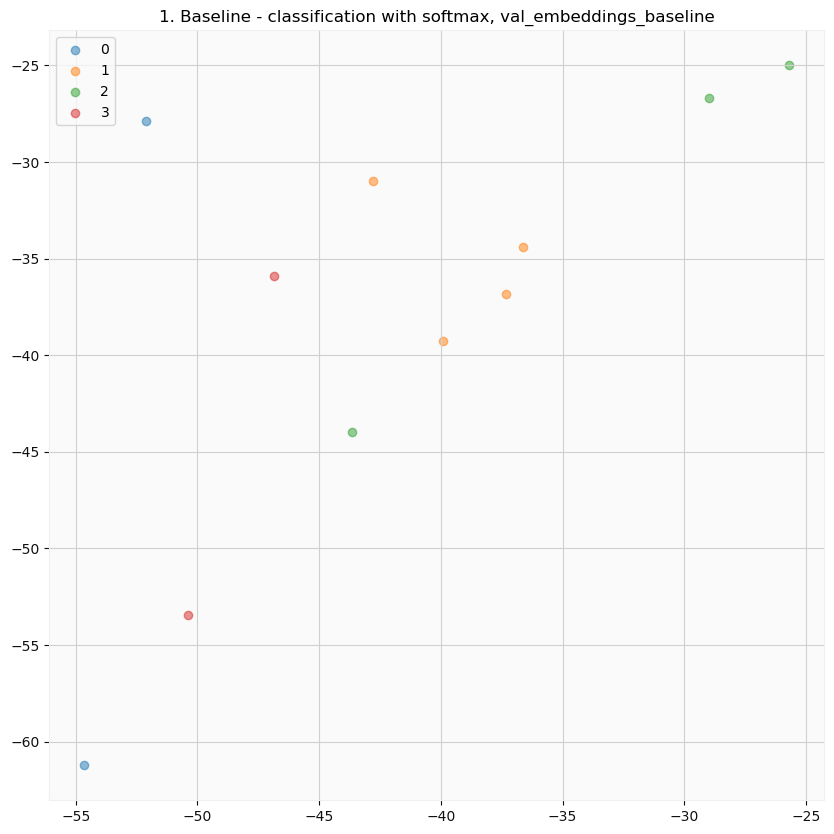

In [10]:
# Baseline: Classification with softmax
# We'll train the model for classification and use outputs of penultimate layer as embeddings
# Set up data loaders
title = '1. Baseline - classification with softmax'
print(f'\n{title}:')
batch_size = 16
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
embedding_net = EmbeddingNet().double()
model = ClassificationNet(embedding_net, n_classes=n_classes).double()
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval,
    metrics=[AccumulatedAccuracyMetric()])

train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline, f'{title}, train_embeddings_baseline')
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline, f'{title}, val_embeddings_baseline')


2. Siamese network:
Train: [0/44 (0%)]	Loss: 1.913810

Epoch: 1/20. Train set: Average loss: 655.4367
Epoch: 1/20. Validation set: Average loss: 1397.9925
Train: [0/44 (0%)]	Loss: 875.711333

Epoch: 2/20. Train set: Average loss: 370.6050
Epoch: 2/20. Validation set: Average loss: 86.3062
Train: [0/44 (0%)]	Loss: 88.409123

Epoch: 3/20. Train set: Average loss: 156.0838
Epoch: 3/20. Validation set: Average loss: 11.2367
Train: [0/44 (0%)]	Loss: 41.942388

Epoch: 4/20. Train set: Average loss: 27.9991
Epoch: 4/20. Validation set: Average loss: 24.6061
Train: [0/44 (0%)]	Loss: 123.682094

Epoch: 5/20. Train set: Average loss: 61.4431
Epoch: 5/20. Validation set: Average loss: 17.3886
Train: [0/44 (0%)]	Loss: 6.062910

Epoch: 6/20. Train set: Average loss: 23.8947
Epoch: 6/20. Validation set: Average loss: 1.0796
Train: [0/44 (0%)]	Loss: 3.579351

Epoch: 7/20. Train set: Average loss: 6.3714
Epoch: 7/20. Validation set: Average loss: 1.0645
Train: [0/44 (0%)]	Loss: 4.075479

Epoch: 8/20.

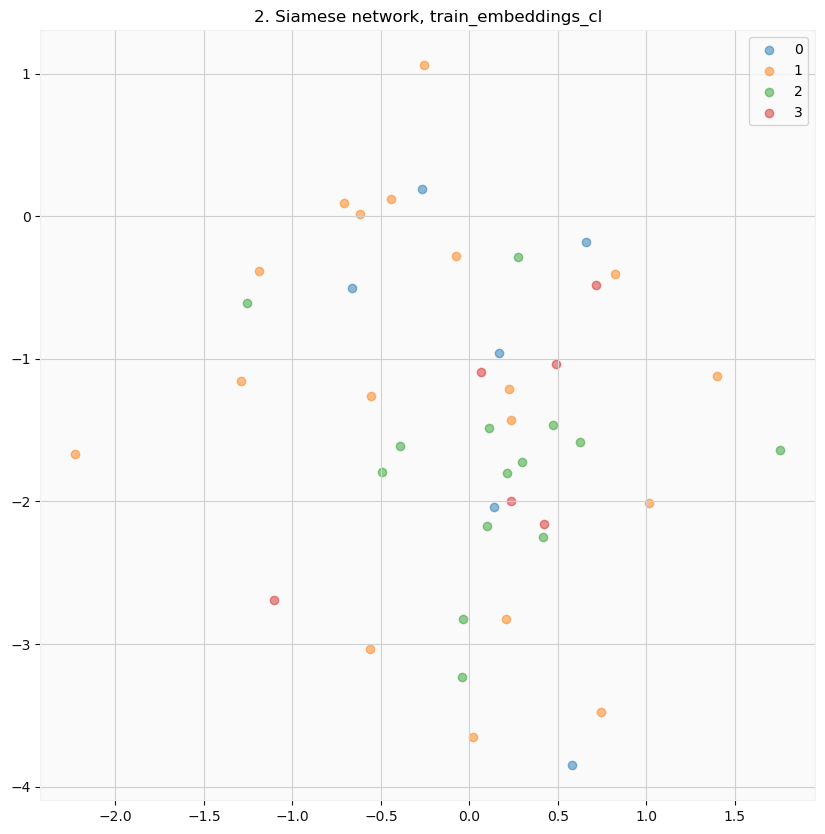

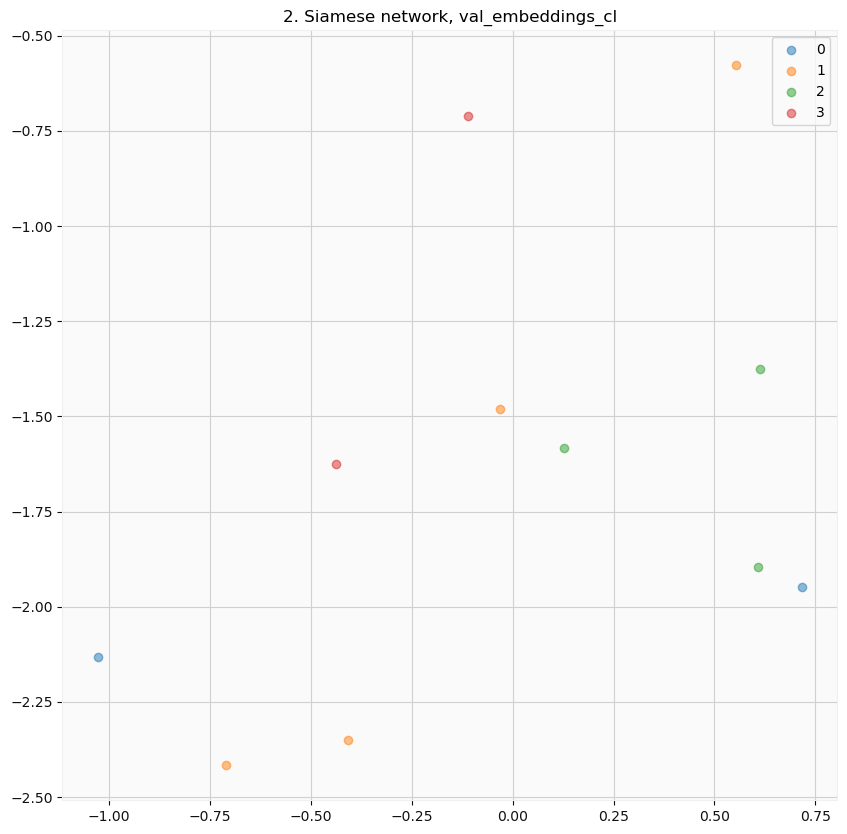

In [11]:
cuda = torch.cuda.is_available()

title = '2. Siamese network'
print(f'\n{title}:')
siamese_train_dataset = SiameseMNIST(x=x_train, y=y_train, train=True) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(x=x_test, y=y_test, train=False)
batch_size = 16
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)


# Set up the network and training parameters
margin = 1.
embedding_net = EmbeddingNet().double()
model = SiameseNet(embedding_net).double()
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

fit(siamese_train_loader, siamese_test_loader, model,
     loss_fn, optimizer, scheduler, n_epochs, cuda,
       log_interval)

train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl, f'{title}, train_embeddings_cl')
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl, f'{title}, val_embeddings_cl')


3. Triplet network:
Train: [0/44 (0%)]	Loss: 41.338095

Epoch: 1/5. Train set: Average loss: 5532.5087
Epoch: 1/5. Validation set: Average loss: 275.5812
Train: [0/44 (0%)]	Loss: 6691.763298

Epoch: 2/5. Train set: Average loss: 4223.0958
Epoch: 2/5. Validation set: Average loss: 311.4603
Train: [0/44 (0%)]	Loss: 314.797462

Epoch: 3/5. Train set: Average loss: 470.1864
Epoch: 3/5. Validation set: Average loss: 169.2524
Train: [0/44 (0%)]	Loss: 886.345480

Epoch: 4/5. Train set: Average loss: 393.6155
Epoch: 4/5. Validation set: Average loss: 72.3901
Train: [0/44 (0%)]	Loss: 119.834621

Epoch: 5/5. Train set: Average loss: 233.1839
Epoch: 5/5. Validation set: Average loss: 163.2211


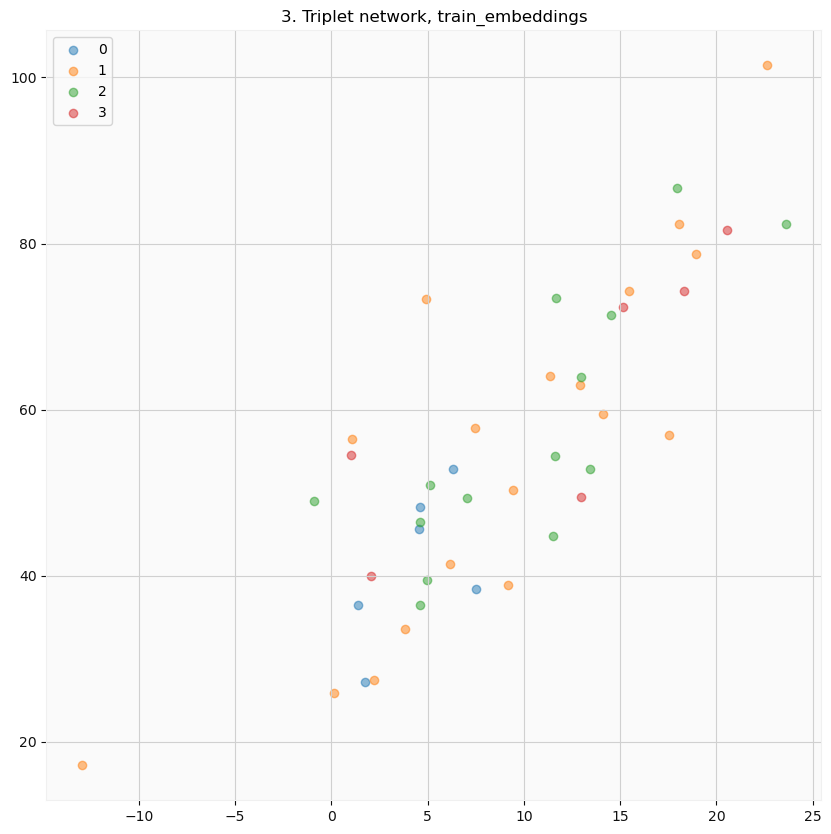

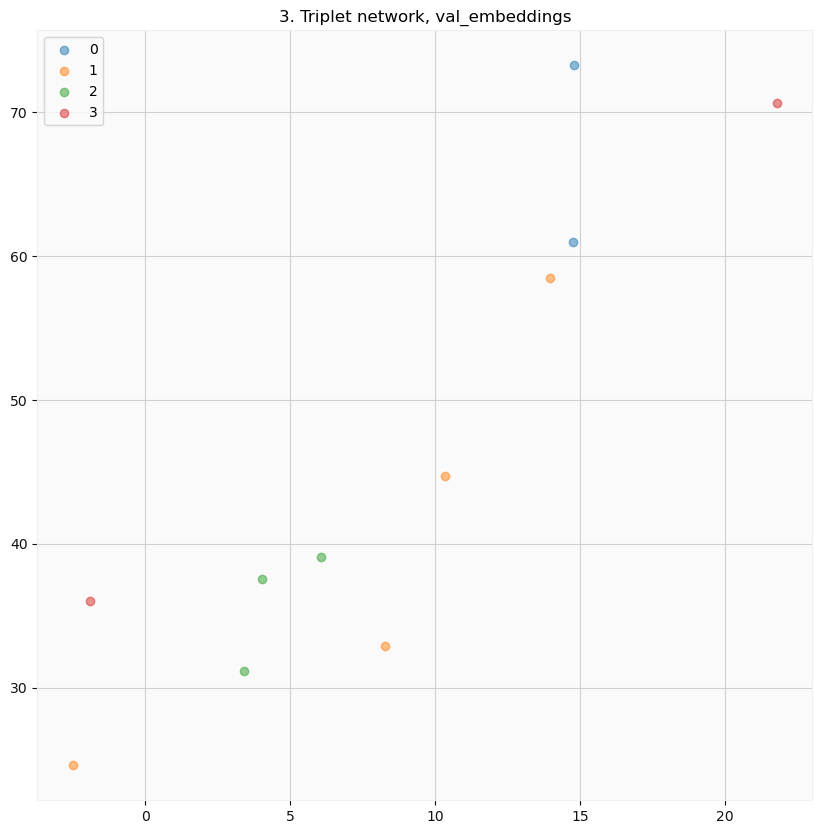

In [12]:
# Triplet network
# We'll train a triplet network, that takes an anchor, positive (same class as anchor)
# and negative (different class than anchor) examples.
# The objective is to learn embeddings such that the anchor is closer to the positive example
# than it is to the negative example by some margin value.
title = '3. Triplet network'
print(f'\n{title}:')
# Set up data loaders
triplet_train_dataset = TripletMNIST(x=x_train, y=y_train, train=True) # Returns triplets of images
triplet_test_dataset = TripletMNIST(x=x_test, y=y_test, train=False)
batch_size = 16
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
margin = 1.
embedding_net = EmbeddingNet().double()
model = TripletNet(embedding_net).double()
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 5
log_interval = 100

fit(triplet_train_loader, triplet_test_loader, model,
     loss_fn, optimizer, scheduler, n_epochs, cuda,
       log_interval)

train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl, f'{title}, train_embeddings')
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl, f'{title}, val_embeddings')


4. Online pair selection - negative mining:
Train: [0/44 (0%)]	Loss: 26.570195

Epoch: 1/20. Train set: Average loss: 3167.2092
Epoch: 1/20. Validation set: Average loss: 1731.2798
Train: [0/44 (0%)]	Loss: 1166.653411

Epoch: 2/20. Train set: Average loss: 895.5264
Epoch: 2/20. Validation set: Average loss: 105.6523
Train: [0/44 (0%)]	Loss: 651.953410

Epoch: 3/20. Train set: Average loss: 522.3322
Epoch: 3/20. Validation set: Average loss: 562.0001
Train: [0/44 (0%)]	Loss: 295.368345

Epoch: 4/20. Train set: Average loss: 373.8941
Epoch: 4/20. Validation set: Average loss: 53.0072
Train: [0/44 (0%)]	Loss: 187.045754

Epoch: 5/20. Train set: Average loss: 165.1512
Epoch: 5/20. Validation set: Average loss: 93.5156
Train: [0/44 (0%)]	Loss: 166.779310

Epoch: 6/20. Train set: Average loss: 194.3501
Epoch: 6/20. Validation set: Average loss: 37.9673
Train: [0/44 (0%)]	Loss: 86.283587

Epoch: 7/20. Train set: Average loss: 57.9251
Epoch: 7/20. Validation set: Average loss: 17.3695
Train: 

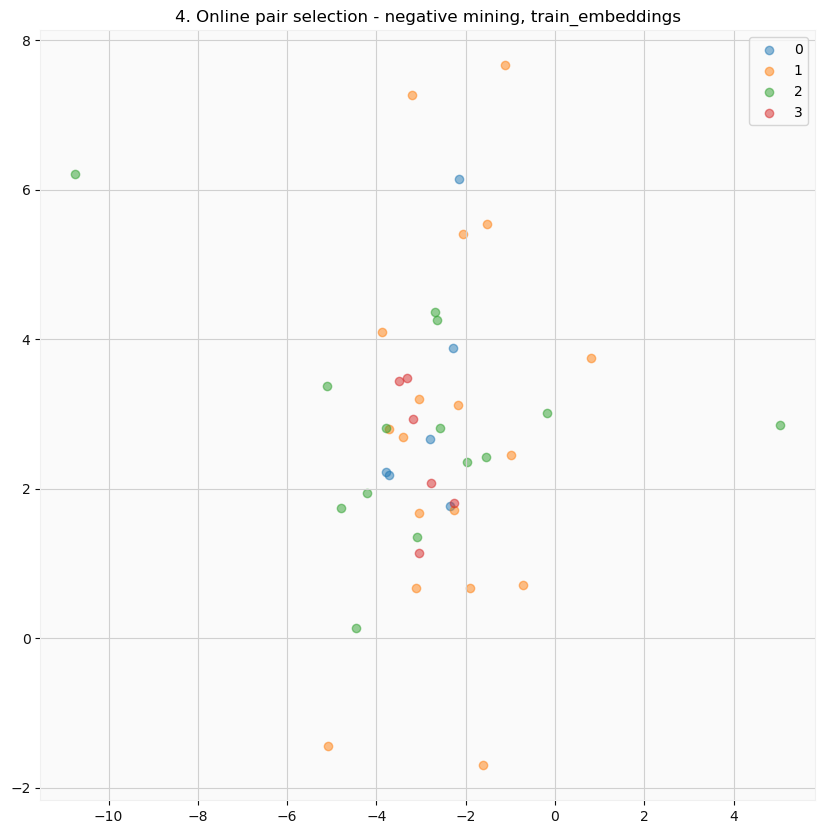

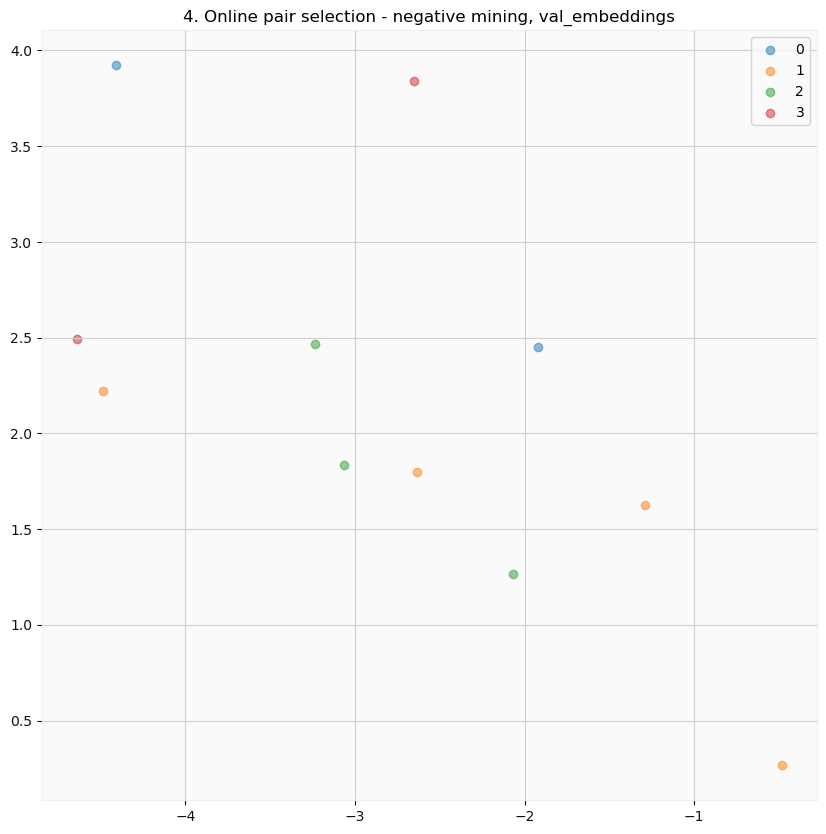

In [13]:
## Online pair selection
## Steps
# 1. Create BalancedBatchSampler - samples N  classes and M samples datasets.py
# 2. Create data loaders with the batch sampler Define embedding (mapping) network f(x) - EmbeddingNet from networks.py
# 3. Define a PairSelector that takes embeddings and original labels and returns valid pairs within a minibatch
# 4. Define OnlineContrastiveLoss that will use a PairSelector and compute ContrastiveLoss on such pairs
# 5. Train the network!
title = '4. Online pair selection - negative mining'
print(f'\n{title}:')
# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(y_train, n_classes=4, n_samples=4)
test_batch_sampler = BalancedBatchSampler(y_test, n_classes=4, n_samples=2)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
margin = 1.
embedding_net = EmbeddingNet().double()
model = embedding_net.double()
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

fit(online_train_loader, online_test_loader, model,
     loss_fn, optimizer, scheduler, n_epochs, cuda,
       log_interval)

train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl, f'{title}, train_embeddings')
val_embeddings_ocl, val_labels_ocl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl, f'{title}, val_embeddings')


5. Online triplet selection - negative mining:
Train: [0/44 (0%)]	Loss: 268.208414

Epoch: 1/20. Train set: Average loss: 15017.4079
Epoch: 1/20. Validation set: Average loss: 29105.6713
Train: [0/44 (0%)]	Loss: 19800.836785

Epoch: 2/20. Train set: Average loss: 9790.5412
Epoch: 2/20. Validation set: Average loss: 1430.5786
Train: [0/44 (0%)]	Loss: 881.279942

Epoch: 3/20. Train set: Average loss: 2767.0484
Epoch: 3/20. Validation set: Average loss: 1079.0338
Train: [0/44 (0%)]	Loss: 746.621843

Epoch: 4/20. Train set: Average loss: 645.7105
Epoch: 4/20. Validation set: Average loss: 169.4523
Train: [0/44 (0%)]	Loss: 744.511965

Epoch: 5/20. Train set: Average loss: 459.3549
Epoch: 5/20. Validation set: Average loss: 74.5839
Train: [0/44 (0%)]	Loss: 150.485174

Epoch: 6/20. Train set: Average loss: 170.6645
Epoch: 6/20. Validation set: Average loss: 180.6291
Train: [0/44 (0%)]	Loss: 115.913203

Epoch: 7/20. Train set: Average loss: 157.9356
Epoch: 7/20. Validation set: Average loss: 

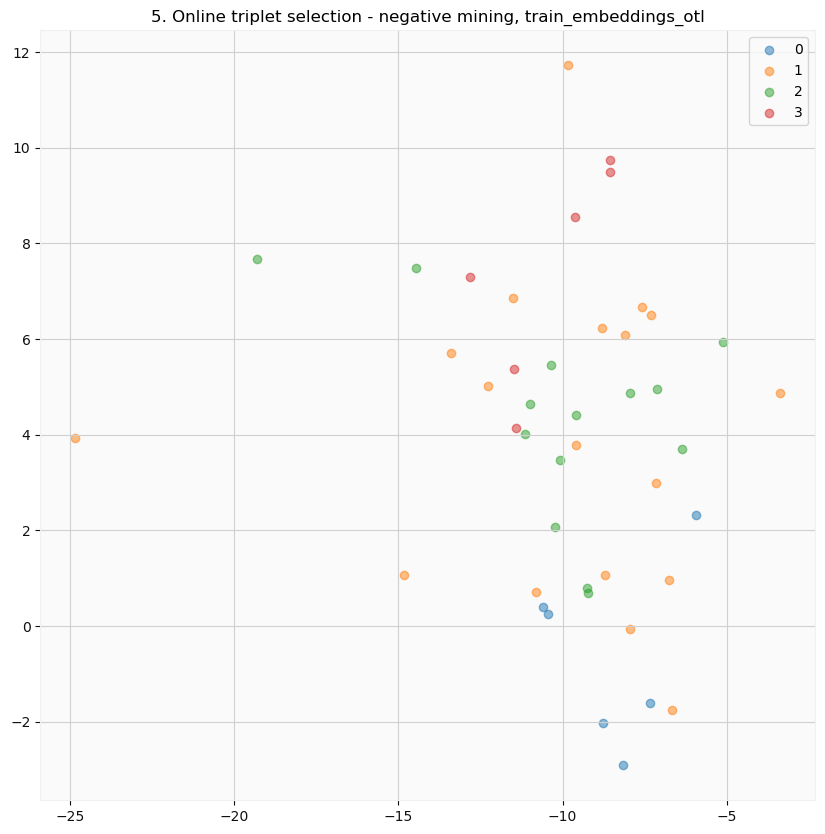

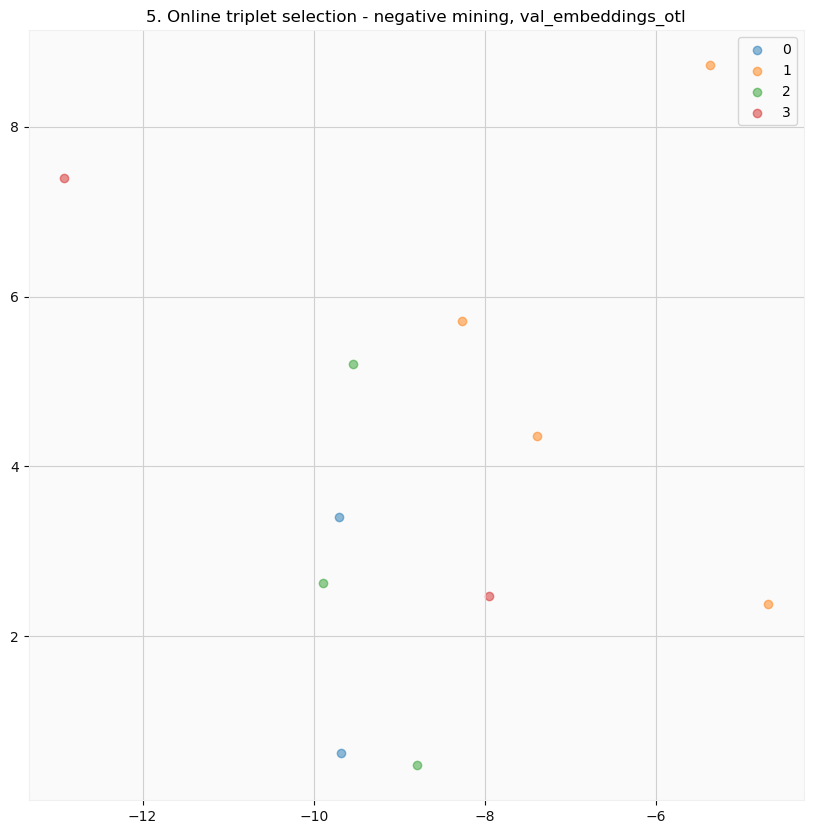

In [14]:

## Online triplet selection
## Steps
# 1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
# 2. Create data loaders with the batch sampler
# 3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
# 4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
# 5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
# 6. Train the network!
title = '5. Online triplet selection - negative mining'
print(f'\n{title}:')
# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(y_train, n_classes=4, n_samples=3)
test_batch_sampler = BalancedBatchSampler(y_test, n_classes=4, n_samples=2)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
margin = 1.
embedding_net = EmbeddingNet().double()
model = embedding_net.double()
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl, f'{title}, train_embeddings_otl')
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl, f'{title}, val_embeddings_otl')